# Ungraded Lab: Transfer Learning

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow_Developer_Professional_Certificate/blob/master/Convolutional_Neural_Networks_in_TensorFlow/Week3/Labs/C2_W3_Lab_1_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Setup the pretrained model

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, you want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because you will be replacing it later. You will also specify the input shape that your model will accept. Lastly, you want to freeze the weights of these layers because they have been trained already.

In [1]:
%%bash

mkdir models

# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
wget -q https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 -P ./models

# Download the dataset
wget -q https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [2]:
from keras import layers, applications, Model, optimizers, utils, Input, Sequential
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-12 21:03:20.854319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Set the weights file you downloaded into a variable
local_weights_file = './models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = applications.inception_v3.InceptionV3(input_shape=(150, 150, 3),
                                                          include_top=False,
                                                          weights=None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

2024-06-12 21:03:24.049459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1680 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to `mixed7` as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. `mixed7` on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [4]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [5]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [7]:
# Set the training parameters
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Prepare the dataset

Now you will prepare the dataset. This is basically the same code as the one you used in the data augmentation lab.

In [8]:
# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall()
zip_ref.close()

!rm ./cats_and_dogs_filtered.zip

In [9]:
# Define our example directories and files
base_dir = './cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [10]:
# Add our data-augmentation parameters to ImageDataGenerator
augmentation = Sequential([layers.Rescaling(scale=1. / 255),
                           layers.RandomRotation(factor=0.2, fill_mode="nearest"),
                           layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest"),
                           layers.RandomFlip(mode="horizontal")])

# Note that the validation data should not be augmented!
scale = layers.Rescaling(scale=1. / 255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = utils.image_dataset_from_directory(directory=train_dir,
                                                     batch_size=20,
                                                     image_size=(150, 150),
                                                     label_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = utils.image_dataset_from_directory(directory=validation_dir,
                                                          batch_size=20,
                                                          image_size=(150, 150),
                                                          label_mode='binary')

train_generator = train_generator.map(lambda image, label: (augmentation(image, training=True), label), num_parallel_calls=tf.data.AUTOTUNE)
validation_generator = validation_generator.map(lambda image, label: (scale(image), label))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Train the model

With that, you can now train the model. You will do 20 epochs and plot the results afterwards.

In [11]:
# Train the model.
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    # steps_per_epoch = 100,
                    epochs=20,
                    # validation_steps = 50,
                    verbose=2)

Epoch 1/20


I0000 00:00:1718247813.715387  195843 service.cc:145] XLA service 0x7fa054040c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718247813.715426  195843 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-06-12 21:03:33.869452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-12 21:03:35.098251: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718247821.344940  195843 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 - 21s - 205ms/step - accuracy: 0.8140 - loss: 0.4301 - val_accuracy: 0.9510 - val_loss: 0.1043
Epoch 2/20
100/100 - 5s - 49ms/step - accuracy: 0.8695 - loss: 0.2900 - val_accuracy: 0.9430 - val_loss: 0.1634
Epoch 3/20
100/100 - 5s - 50ms/step - accuracy: 0.8835 - loss: 0.2708 - val_accuracy: 0.9570 - val_loss: 0.1022
Epoch 4/20
100/100 - 5s - 49ms/step - accuracy: 0.8995 - loss: 0.2362 - val_accuracy: 0.9660 - val_loss: 0.0915
Epoch 5/20
100/100 - 5s - 49ms/step - accuracy: 0.8895 - loss: 0.2524 - val_accuracy: 0.9660 - val_loss: 0.0851
Epoch 6/20
100/100 - 5s - 49ms/step - accuracy: 0.9010 - loss: 0.2378 - val_accuracy: 0.9680 - val_loss: 0.0759
Epoch 7/20
100/100 - 5s - 49ms/step - accuracy: 0.9040 - loss: 0.2421 - val_accuracy: 0.9480 - val_loss: 0.1518
Epoch 8/20
100/100 - 5s - 49ms/step - accuracy: 0.9205 - loss: 0.2049 - val_accuracy: 0.9680 - val_loss: 0.0856
Epoch 9/20
100/100 - 5s - 50ms/step - accuracy: 0.9035 - loss: 0.2221 - val_accuracy: 0.9620 - val_loss: 0.0976
E

## Evaluate the results

You will use the same code to plot the results. As you can see, the validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that your model is no longer overfitting!

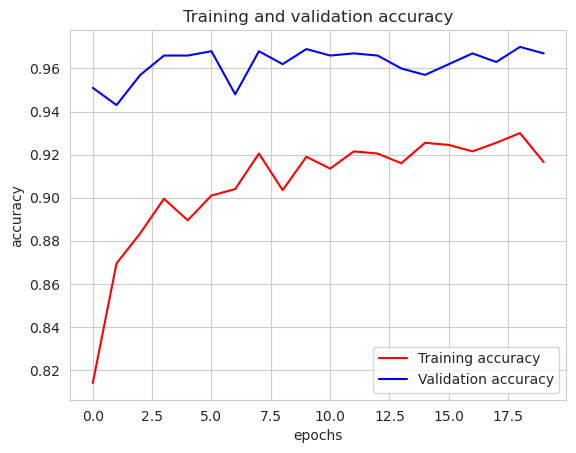

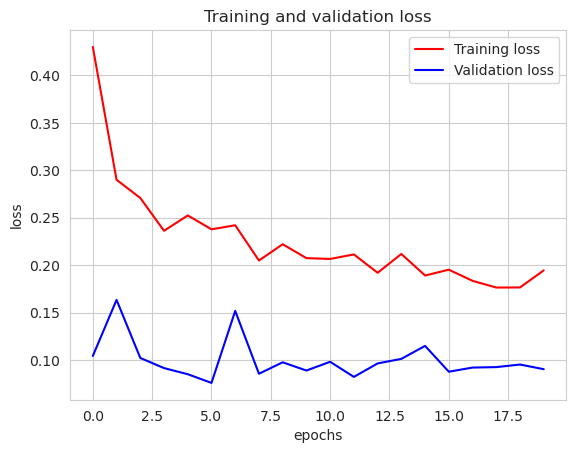

In [13]:
sns.set_style("whitegrid")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc=0)
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc=0)
plt.show()

In [14]:
!rm -rf ./models ./cats*